In [1]:
%run hublib.py

# NanoPlasticity Lab

This tool is used to investigate the competing grain-boundary and dislocation-mediated deformation 
mechanisms in nanocrystalline metals. The model is based on a multi phase field model in which
dislocation and grain boundary sliding are represented by means of scalar phase fields described
in “The role of grain boundary energetics on the maximum strength of nanocrystalline Ni”,
Koslowski, Lee and Lei, <em>Journal of the Mechanics and Physics of Solids</em>,
59 1427-1436, 2011.

The simulations are carried out with periodic boundary conditions. As a simplification we assume
that all the grains have the same orientation with the (111) direction shown in the figure below.
The samples that can be simulated have grain sizes in the range 8 to 128 Burgers vectors.
Grain boundaries are assumed to be planar and we consider grain boundary sliding tangential
to the grain boundary surface. Under an externally applied stress the sample deforms plastically
by dislocation nucleation and gliding and by grain boundary sliding. We track individual
dislocations inside each grain and we include grain boundaries as interfaces impenetrable to
dislocations.
<img src='nano1.png'>

In [2]:
# display controls
tabs = Tab()
for i, t in enumerate(['Sample', 'Elastic Constants', 'Plasticity', 'Loading Conditions']): 
    tabs.set_title(i, t)
    
v1 = UQVar('burgers', 'Burgers Vector (nm)', 'Exact', 0.25)
v2 = IntSlider(description='d1,d2,d3 (Burgers vectors)', value=32, min=8, max=32, step=4)
v3 = UQVar('young', "Young's Modulus (GPa)", 'Gaussian', 200, 10)
v4 = UQVar('poisson', "Poisson's Ratio", 'Exact', 0.3)
v5 = UQVar('peierls', "Dislocation Glide: Peierl's Energy Barrier (J/m^2)", 'Gaussian', .6, .06)
v6 = UQVar('glide', "Grain Boundary Sliding: Energy Barrier (J/m^2)", 'Exact', 0.15)
v7 = FloatText(description='Stress Scaling Factor', value=1)
v8 = FloatText(description='Maximum Strain', value=0.5)
level = IntSlider(description='GPC Level', value=2, min=1, max=6)
tabs.children = [VBox([v1.form, v2]), VBox([v3.form, v4.form]), VBox([v5.form, v6.form]), VBox([v7, v8, level])]
display(tabs)


In [3]:
%wait Run,Submitted: Please Wait

Saving run to foo.hdf5

Processing <HDF5 dataset "stress": shape (13,), type "<f8">
	Surface   = -23.6858390071929*peierls**2 - 0.000980737922108059*peierls*young + 33.520845791763*peierls - 7.7899568449921e-5*young**2 + 0.0373606869074169*young - 5.55745278907621
	RMSE      = 1.24e-01 (5.27e+00 %)

SENSITIVITY:
Var            u*            dev
-----------------------------------
peierls    2.6525e+00    2.6495e+00
  young    3.2556e-01    2.3137e-01


<IPython.core.display.Javascript object>


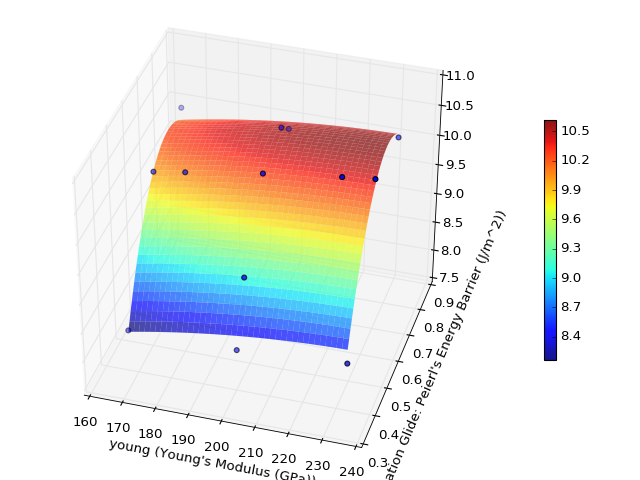

In [4]:
# UQRun expects all constants to be a list of [name, label, value]
d1 = ['d1', 'Burgers Vectors', v2.value]
d2 = ['d2', 'Burgers Vectors', v2.value]
d3 = ['d3', 'Burgers Vectors', v2.value]
ss = ['stress_scale', 'Stress Scaling Factor', v7.value]
ms = ['max_strain', 'Maximum Strain', v8.value]

cmd = '../slip_wrap.py --N1=$d1 --N2=$d2 --N3=$d3 --Maxstrain=$max_strain \
--Sigscale=$stress_scale --b=$burgers --Young=$young --Poisson=$poisson --Peierls=$peierls --GBEnergy=$glide'
vals = [d1, d2, d3, ss, ms, v1.value, v3.value, v4.value, v5.value, v6.value]
u = UQRun('GPC', level.value, cmd, vals, outfiles=['stress-strain.dat'], newdir=True)
u.plot_responses()

In [5]:
%wait Plot,Plotting

<IPython.core.display.Javascript object>


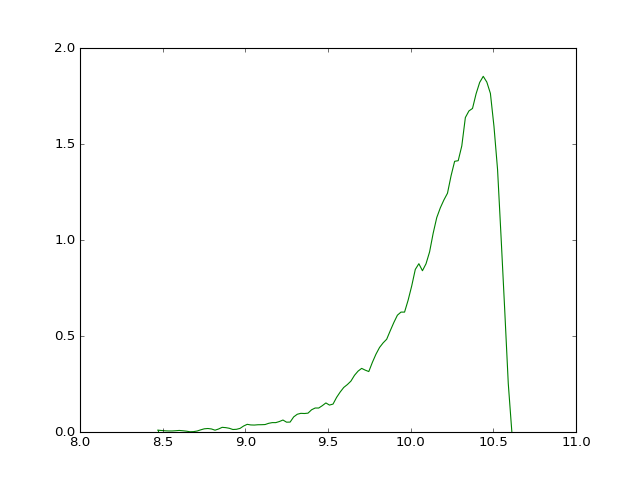

In [6]:
u.plot_pdfs()

In [7]:
from scipy import interpolate, optimize

def plot_yield(hf, j, total_jobs, pdata):
    data = hf['output/jobs/%s/stress-strain.dat' % j].value.split()
    data = np.array(map(float, data)).reshape(-1, 2)
    x = data[:,0]
    y = data[:,1]

    numpts=200
    f = interpolate.interp1d(x, y, kind='linear')
    xx = np.linspace(np.min(x), np.max(x), numpts)
    xline = np.array([np.min(x), np.max(x)])

    # calculate slope using points with strain <= 0.02
    sx = x[x<=.02]
    sy = y[x<=.02]
    A = np.array([sx, np.ones(len(sx))]).T
    slope = np.linalg.lstsq(A, sy)[0][0]

    offset = .002
    linef = lambda x: (x-offset)*slope
    yline = linef(xline)

    # calculate intersection
    yint = np.inf
    g = np.array([(s, f(s)-linef(s)) for s in xx])
    for i in range(0, len(g)):
        if i < numpts-2 and g[i][1]*g[i+1][1] <= 0:
            xint = optimize.brentq(lambda x: f(x)-linef(x), g[i][0], g[i+1][0])
            yint = float(f(xint))

    # truncate to region we care about
    x = x[x<xint*1.75]
    y = y[x<xint*1.75]
    #xx = np.linspace(np.min(x), xint *1.75, numpts)
    #xline = np.array([np.min(x), xint*1.75])
    #yline = linef(xline)
    
    t1 = Scatter(x=x, y=y, mode='lines',name='Job %s' % j)
    t2 = Scatter(x=[xint], y=[yint], mode='marker', marker=Marker(color='black'), 
                 showlegend=False, text='Yield Stress', name='Job %s' % j)

    pdata.append(t1)
    pdata.append(t2)

    return pdata
        
def plot_yield_curves(hf):
    jobs = [str(k) for k in hf['output/jobs'] if k != 'time']
    layout = Layout(title='Fig 1: Stress-Strain')
    data = []
    for j in jobs:
        data = plot_yield(hf, j, len(jobs), data)
    #layout = Layout(title='Fig 1: Stress-Strain')
    fig = Figure(data=data, layout=layout)
    return py.iplot(fig, filename='stress-strain')
    
plot_yield_curves(u.hf)


/opt/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 49

/opt/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 0; dimension is 85 but corresponding boolean dimension is 56

/opt/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 0; dimension is 80 but corresponding boolean dimension is 44

/opt/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 0; dimension is 55 but corresponding boolean dimension is 47

/opt/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning:

boole

In [8]:
%waitdone

In [ ]:

FIXME CHANGE PLOT TO USE SEABORN
def plot_yield_curves2(hf):
    jobs = [str(k) for k in hf['output/jobs'] if k != 'time']
    layout = Layout(title='Fig 1: Stress-Strain')
    data = []
    for j in jobs:
        
        data = plot_yield(hf, j, len(jobs), data)
    #layout = Layout(title='Fig 1: Stress-Strain')
    fig = Figure(data=data, layout=layout)
    return py.iplot(fig, filename='stress-strain')
    
plot_yield_curves(u.hf)